In [32]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import streamlit as st
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

In [ ]:
def data_clean_global_temperatures(csv_path):
    data = pd.read_csv(csv_path)
    
    data['dt'] = pd.to_datetime(data['dt'])  # Convert from string to datetime format
    data_clean = data.dropna(subset=['LandAverageTemperature']).copy()  # Work on a copy after dropping rows with NaN
    data_clean = data_clean.ffill()  # Fill missing values using forward fill
    data_clean = data_clean.drop_duplicates()  # Drop duplicate rows
    data_clean.columns = [col.lower() for col in data_clean.columns]  # Make column names lowercase

    return data_clean

# Load and clean the CSV file
csv_path = 'data/GlobalTemperatures.csv'
data_cleaned = data_clean_global_temperatures(csv_path)


In [34]:
# load into the project the map of the world
world = gpd.read_file("map/ne_10m_admin_0_countries.shp") 
world = world.explode(index_parts=False)

# Reproject to a projected CRS for accurate centroid calculations
world = world.to_crs(epsg=3857)  # Web Mercator projection for compatibility

# We filter the file for print only the europe, and we delete russia and other far land for a better visualization of the map
europe = world[(world['CONTINENT'] == 'Europe') & (world['SOVEREIGNT'] != 'Russia')]

# Apply geographic bounds in the projected CRS
europe = europe[(europe.geometry.centroid.y > 4200000) & (europe.geometry.centroid.y < 9300000) &
                (europe.geometry.centroid.x > -3000000) & (europe.geometry.centroid.x < 5700000)]

europe['SOVEREIGNT'] = europe['SOVEREIGNT'].replace({
    "Czechia": "Czech Republic",
    "Republic of Serbia": "Serbia"
})

# Reproject back to WGS84 for visualization
europe = europe.to_crs(epsg=4326)

In [35]:
def clean_coordinates(df, lat_col = 'Latitude', lon_col = 'Longitude'):
    df['dt'] = pd.to_datetime(df['dt'])
    def clean_lat_lon(value):
        # Remove non-numeric characters except for "N", "S", "E", and "W"
        if isinstance(value, str):
            if value[-1] == 'N':
                return float(value[:-1])  # North is positive
            elif value[-1] == 'S':
                return -float(value[:-1])  # South is negative

            elif value[-1] == 'E':
                return float(value[:-1])  # East is positive
            elif value[-1] == 'W':
                return -float(value[:-1])  # West is negative
        return float(value)  # If already clean, just convert to float

    # Apply cleaning function to latitude and longitude columns
    df[lat_col] = df[lat_col].apply(clean_lat_lon)
    df[lon_col] = df[lon_col].apply(clean_lat_lon)
    
    return df

# load the csv
europe_csv = pd.read_csv('data/europe_city.csv')

# we must clean the cordinates, because it contains some char value like N for North
europe_csv = clean_coordinates(europe_csv, lat_col = 'Latitude', lon_col = 'Longitude')

In [36]:
print(data_cleaned.head(100))

            dt  landaveragetemperature  landaveragetemperatureuncertainty  \
0   1750-01-01                   3.034                              3.574   
1   1750-02-01                   3.083                              3.702   
2   1750-03-01                   5.626                              3.076   
3   1750-04-01                   8.490                              2.451   
4   1750-05-01                  11.573                              2.072   
..         ...                     ...                                ...   
107 1758-12-01                   3.249                              3.244   
108 1759-01-01                   5.014                              3.673   
109 1759-02-01                   4.082                              5.966   
110 1759-03-01                   4.520                              3.958   
111 1759-04-01                   5.983                              3.159   

     landmaxtemperature  landmaxtemperatureuncertainty  landmintemperature 

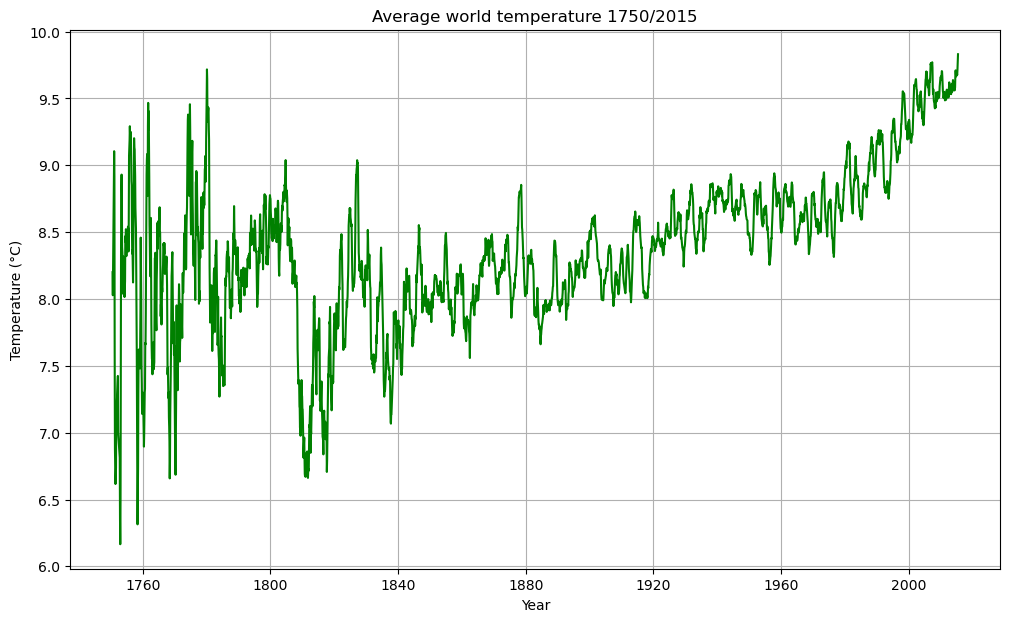

In [37]:
def temperature_graph(data_temperature_graph, color_graph, title_temperature):
    """
    Plot graph
    
    Parameters:
    - data_temperature_graph: The data to print.
    - color_graph: The color of the graph.
    - title_temperature: the title of the graph.
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(data_temperature_graph['dt'], data_temperature_graph['smoothedtemperature'], label='Average temperature', color=color_graph)
    ax.set_title(title_temperature)
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True)

    return fig

# we want a graph to visualize better the change of temperatures
data_cleaned['smoothedtemperature'] = data_cleaned['landaveragetemperature'].rolling(window = 12, center = True).mean()
data_cleaned.set_index(data_cleaned['dt'], inplace=True)
graph1 = temperature_graph(data_cleaned, 'green', 'Average world temperature 1750/2015')

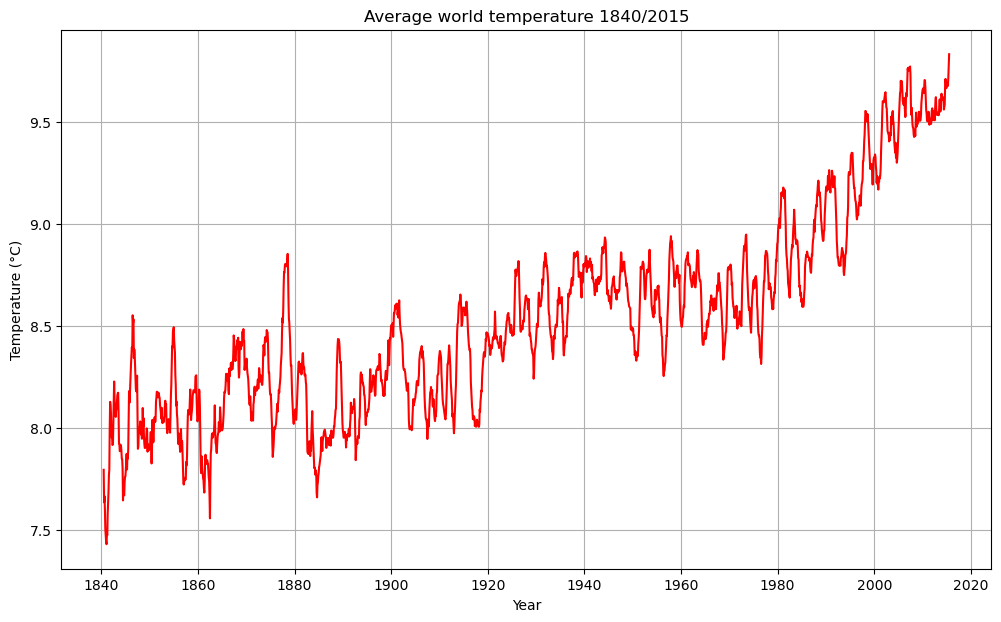

In [38]:
# we saw that the first data of the graph are not correct, probably. So we print only the data starting from 1840
data_filtered = data_cleaned[(data_cleaned['dt'] >= '1840-01-01') & (data_cleaned['dt'] <= '2015-12-31')].copy()
data_filtered['smoothedtemperature'] = data_filtered['landaveragetemperature'].rolling(window = 12, center = True).mean()
graph2 = temperature_graph(data_filtered, 'red', 'Average world temperature 1840/2015')

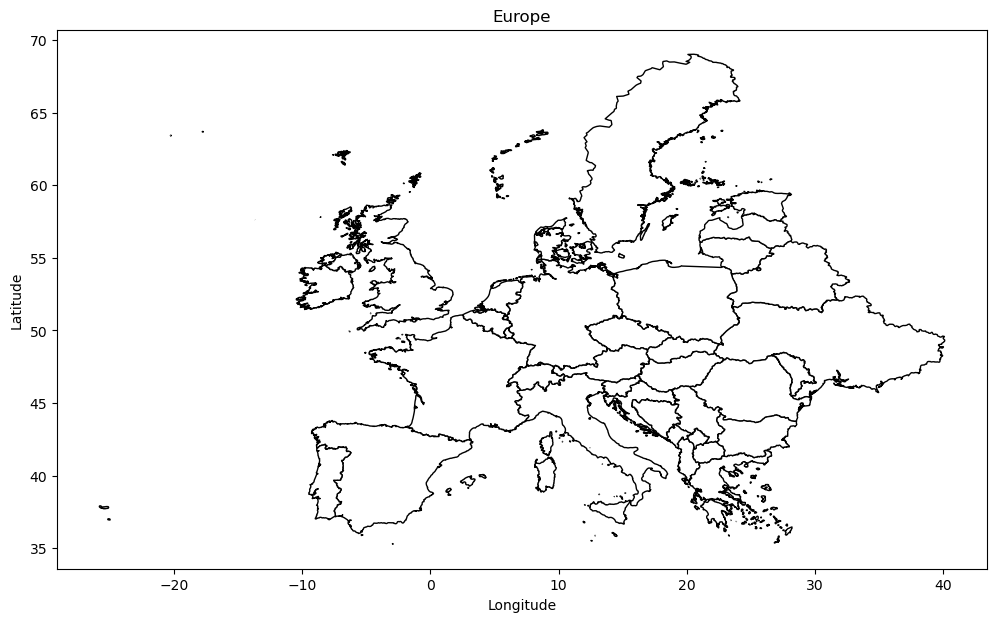

In [39]:
def plot_europe(europe, plot_type = 'outline', state_branches = None, highest_cities = None, lowest_cities = None):
    """
    Plot a map of Europe with optional city points for highest and lowest thermal excursions.

    Parameters:
    - europe: The GeoDataFrame for Europe.
    - plot_type: The type of plot ('outline' or 'temperature').
    - state_branches: DataFrame with 'Country' and 'AverageTemperature' for the temperature map.
    - highest_cities: DataFrame of cities with the highest thermal excursions (plotted in red).
    - lowest_cities: DataFrame of cities with the lowest thermal excursions (plotted in blue).
    """
    fig, ax = plt.subplots(figsize=(12, 7))

    if plot_type == 'outline':
        # Plot just the outline of Europe
        europe.plot(ax=ax, color = 'white', edgecolor = 'black')
        ax.set_title('Europe')
    elif plot_type == 'temperature' and state_branches is not None:
        # Merge temperature data with Europe GeoDataFrame
        europe = europe.merge(state_branches, left_on="SOVEREIGNT", right_on="Country", how="left")
        
        # Plot average temperature by country
        europe.plot(column='AverageTemperature', cmap='coolwarm', legend=True, edgecolor='black', ax=ax)
        ax.set_title('Europe - Average Temperature by Country from 1740 to 2015')

    # Plot highest excursion cities in red with bold labels
    if highest_cities is not None:
        ax.scatter(highest_cities['longitude'], highest_cities['latitude'], color='red', s=50, label='Top 10 Highest Excursion')
        
    # Plot lowest excursion cities in blue with bold labels
    if lowest_cities is not None:
        ax.scatter(lowest_cities['longitude'], lowest_cities['latitude'], color='blue', s=50, label='Top 10 Lowest Excursion')
        
    # Add a legend only if there are labeled artists
    if len(ax.get_legend_handles_labels()[0]) > 0:
        ax.legend()

    # Set labels and aspect
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('auto')

    plt.show()

# plot the europe
plot_europe(europe, plot_type = 'outline')

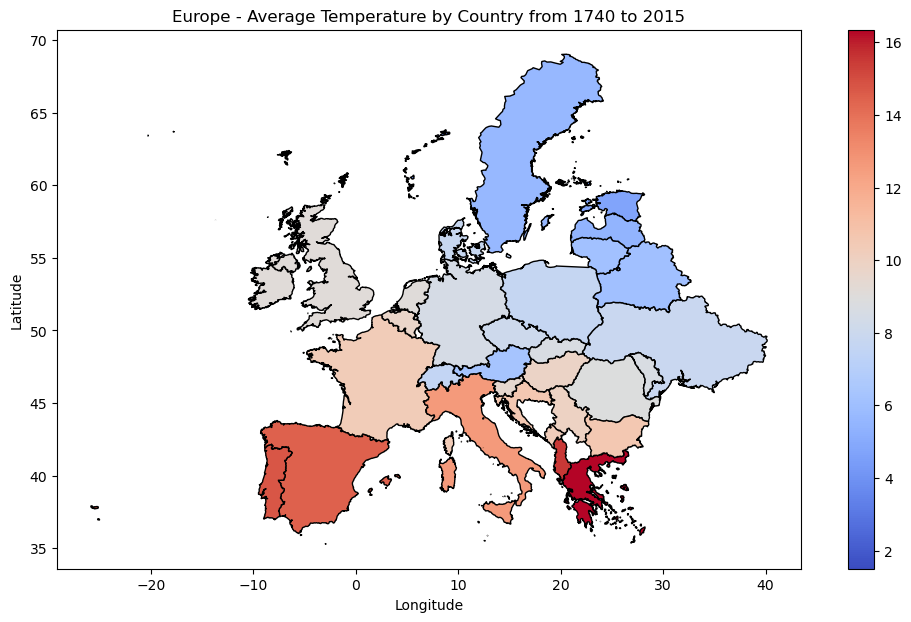

In [40]:
state_branches = europe_csv.groupby('Country')['AverageTemperature'].mean().reset_index()
countries_in_europe = europe.groupby('SOVEREIGNT')

graph3 = plot_europe(europe, plot_type = 'temperature', state_branches = state_branches)

In [41]:
europe = europe.merge(state_branches, left_on="SOVEREIGNT", right_on="Country", how="left")

In [42]:
city_te = europe_csv.groupby(['City', 'Country', 'Latitude', 'Longitude'])['AverageTemperature'].agg(['max', 'min']).reset_index()
city_te['thermal_excursion'] = city_te['max'] - city_te['min']
city_te.columns = ['city', 'country', 'latitude', 'longitude', 'max_temp', 'min_temp', 'thermal_excursion']

In [43]:
top_10_highest_excursion = city_te.nlargest(10, 'thermal_excursion')
print(top_10_highest_excursion)

           city  country  latitude  longitude  max_temp  min_temp  \
187    Horlivka  Ukraine     49.03      39.18    26.140   -17.686   
256   Makiyivka  Ukraine     47.42      39.08    27.413   -15.360   
416        Sumy  Ukraine     50.63      34.23    24.870   -17.299   
311       Orsha  Belarus     53.84      31.36    23.483   -18.537   
326   Pavlohrad  Ukraine     49.03      36.73    25.388   -16.299   
93    Chernihiv  Ukraine     52.24      31.53    24.278   -17.306   
166       Gomel  Belarus     52.24      31.53    24.278   -17.306   
218  Kremenchuk  Ukraine     49.03      34.29    25.392   -15.854   
343     Poltava  Ukraine     49.03      34.29    25.392   -15.854   
209        Kiev  Ukraine     50.63      31.69    24.593   -16.191   

     thermal_excursion  
187             43.826  
256             42.773  
416             42.169  
311             42.020  
326             41.687  
93              41.584  
166             41.584  
218             41.246  
343            

In [44]:
top_10_lowest_excursion = city_te.nsmallest(10, 'thermal_excursion')
print(top_10_lowest_excursion)

                       city         country  latitude  longitude  max_temp  \
220              Las Palmas           Spain     28.13     -15.45    26.283   
391  Santa Cruz De Tenerife           Spain     28.13     -15.45    26.283   
160                   Gijón           Spain     44.20      -6.71    20.667   
67                    Brest          France     49.03      -4.90    18.871   
33                  Belfast  United Kingdom     55.45      -5.67    16.229   
392               Santander           Spain     44.20      -4.47    21.988   
3                  Aberdeen  United Kingdom     57.05      -1.48    16.328   
0                  A Coruña           Spain     42.59      -8.73    22.052   
463                    Vigo           Spain     42.59      -8.73    22.052   
419                 Swansea  United Kingdom     52.24      -5.26    18.445   

     min_temp  thermal_excursion  
220    14.258             12.025  
391    14.258             12.025  
160     5.152             15.515  
6

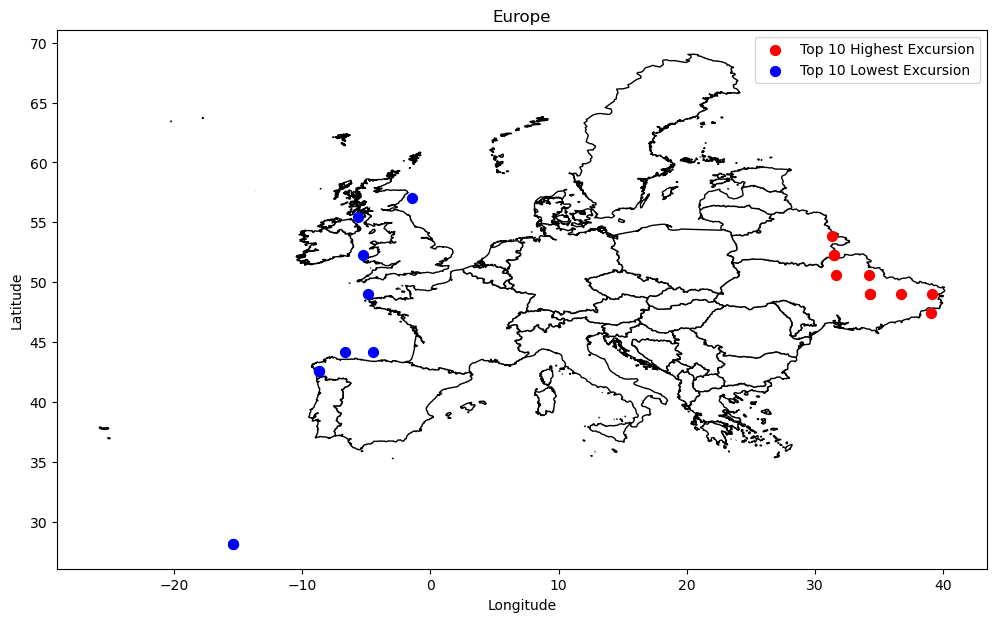

In [45]:
plot_europe(europe, plot_type = 'outline', highest_cities = top_10_highest_excursion, lowest_cities = top_10_lowest_excursion)

In [46]:
def trip_calculator(europe_csv, start_city, final_city):
    recent_temperature_df = europe_csv[europe_csv['dt'] >= '2005-01-01']
    europe_city = recent_temperature_df.groupby(['City', 'Latitude', 'Longitude'])['AverageTemperature'].mean().reset_index()

    print("Initial DataFrame:", europe_city.head())

    cities_already_visited = []
    city_deleted = set()

    city_coords = europe_city[['Latitude', 'Longitude']].values

    def distance_calculation(current_coordinates, cities_not_visited):
        # Calculate distances from the current city to all other cities in cities_not_visited
        distances = np.sqrt(
            (cities_not_visited['Latitude'].values - current_coordinates[0]) ** 2 +
            (cities_not_visited['Longitude'].values - current_coordinates[1]) ** 2
        )
        
        # Get indices of the closest 3 cities
        closest_indices = np.argsort(distances)[:3]
        return cities_not_visited.iloc[closest_indices]['City'].tolist()


    def trip_3_cities(europe_city, cities_already_visited, final_city):
        current_city = cities_already_visited[-1]
        current_city_data = europe_city.query("City == @current_city")
        current_coordinates = np.array([current_city_data['Latitude'].values[0], current_city_data['Longitude'].values[0]])

        # Filter out cities that are already visited or deleted
        cities_not_visited = europe_city[~europe_city['City'].isin(cities_already_visited + list(city_deleted))]

        # Find the names of the 3 closest cities
        closest_3_cities_names = distance_calculation(current_coordinates, cities_not_visited)
        closest_3_cities = cities_not_visited[cities_not_visited['City'].isin(closest_3_cities_names)]

        # Check if final_city is among the closest cities
        if final_city in closest_3_cities['City'].values:
            # If final_city is in the closest 3 cities, prioritize and choose it
            print(f"Final city {final_city} found in closest cities. Prioritizing it.")
            cities_already_visited.append(final_city)
        else:
            # Otherwise, select the city with the highest temperature
            highest_temp_city = closest_3_cities.loc[closest_3_cities['AverageTemperature'].idxmax(), 'City']
            cities_already_visited.append(highest_temp_city)

            # Mark the other two cities as deleted so they are not reconsidered
            for city in closest_3_cities['City']:
                if city != highest_temp_city:
                    city_deleted.add(city)
        
    cities_already_visited.append(start_city)

    # Limit the number of iterations
    max_iterations = 500
    iteration = 0

    while final_city not in cities_already_visited and iteration < max_iterations:
        print(f"Iteration {iteration}: Currently at {cities_already_visited[-1]}")
        trip_3_cities(europe_city, cities_already_visited, final_city)
        iteration += 1

    if final_city in cities_already_visited:
        print(f"Reached {final_city}!")
    else:
        print(f"Reached the iteration limit without reaching {final_city}.")

    print("Trip:", cities_already_visited)
    print("Number of cities visited:", len(cities_already_visited))
    print("Deleted cities:", city_deleted)
    print("Number of cities deleted:", len(city_deleted))

    return cities_already_visited


In [47]:
start_city = 'Berlin'
final_city = 'Almería'
cities_trip = trip_calculator(europe_csv, start_city, final_city)

Initial DataFrame:               City  Latitude  Longitude  AverageTemperature
0         A Coruña     42.59      -8.73           14.026548
1           Aachen     50.63       6.34            9.972452
2          Aalborg     57.05      10.33            8.858471
3         Aberdeen     57.05      -1.48            9.157760
4  Aix En Provence     44.20       4.47           12.439106
Iteration 0: Currently at Berlin
Iteration 1: Currently at Cottbus
Iteration 2: Currently at Chemnitz
Iteration 3: Currently at Ingolstadt
Iteration 4: Currently at Nuremberg
Iteration 5: Currently at Erfurt
Iteration 6: Currently at Brunswick
Iteration 7: Currently at Hildesheim
Iteration 8: Currently at Salzgitter
Iteration 9: Currently at Bremen
Iteration 10: Currently at Bielefeld
Iteration 11: Currently at Bochum
Iteration 12: Currently at Bottrop
Iteration 13: Currently at Dortmund
Iteration 14: Currently at Enschede
Iteration 15: Currently at Hagen
Iteration 16: Currently at Frankfurt
Iteration 17: Currentl

In [48]:
def plot_trip(europe, cities_trip, europe_csv):
    visited_cities = pd.DataFrame({
        'City': cities_trip,
        'Latitude': [europe_csv[europe_csv['City'] == city]['Latitude'].values[0] for city in cities_trip],
        'Longitude': [europe_csv[europe_csv['City'] == city]['Longitude'].values[0] for city in cities_trip]
    })
    
    gdf_visited = gpd.GeoDataFrame(
        visited_cities,
        geometry = gpd.points_from_xy(visited_cities['Longitude'], visited_cities['Latitude']),
        crs="EPSG:4326"
    )

    fig, ax = plt.subplots(figsize=(12, 7))
    europe.plot(ax=ax, color='lightgrey', edgecolor='black')

    gdf_visited.plot(ax=ax, color='blue', marker='o', markersize=50, label='Visited Cities')
    plt.plot(gdf_visited['Longitude'], gdf_visited['Latitude'], color='red', linewidth=2, linestyle='-', label='Route')

    plt.legend()
    plt.title("Percorso")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.show()

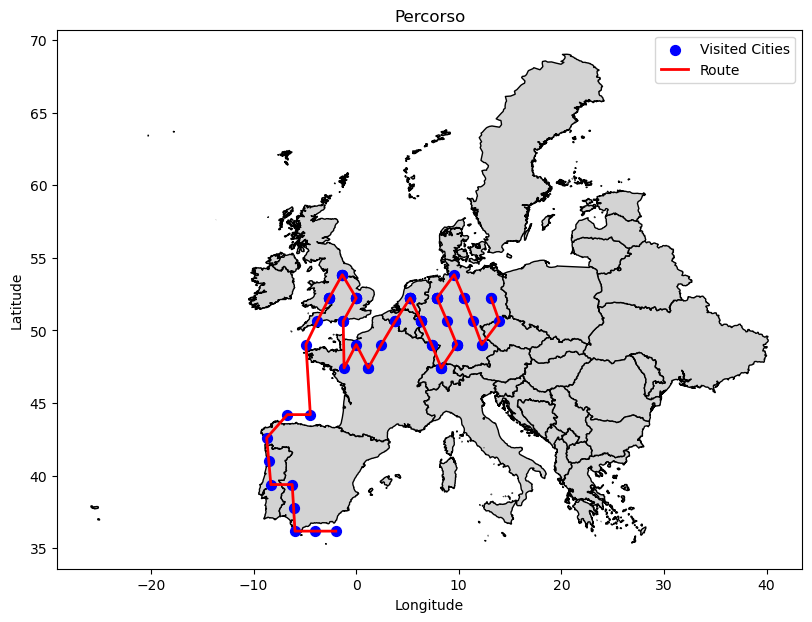

In [49]:
# plot the trip only if cities_trip is successfully calculated
plot_trip(europe, cities_trip, europe_csv)